# **1. Library**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# matplotlib 폰트설정
# plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rc('font', family='NanumGothic') # For Windows

# **2. Data Loading**

In [2]:
train = pd.read_csv("./data/train.csv")
bus_bts = pd.read_csv("./data/bus_bts.csv")

# **3. 일자별 출퇴근 버스 이용량**

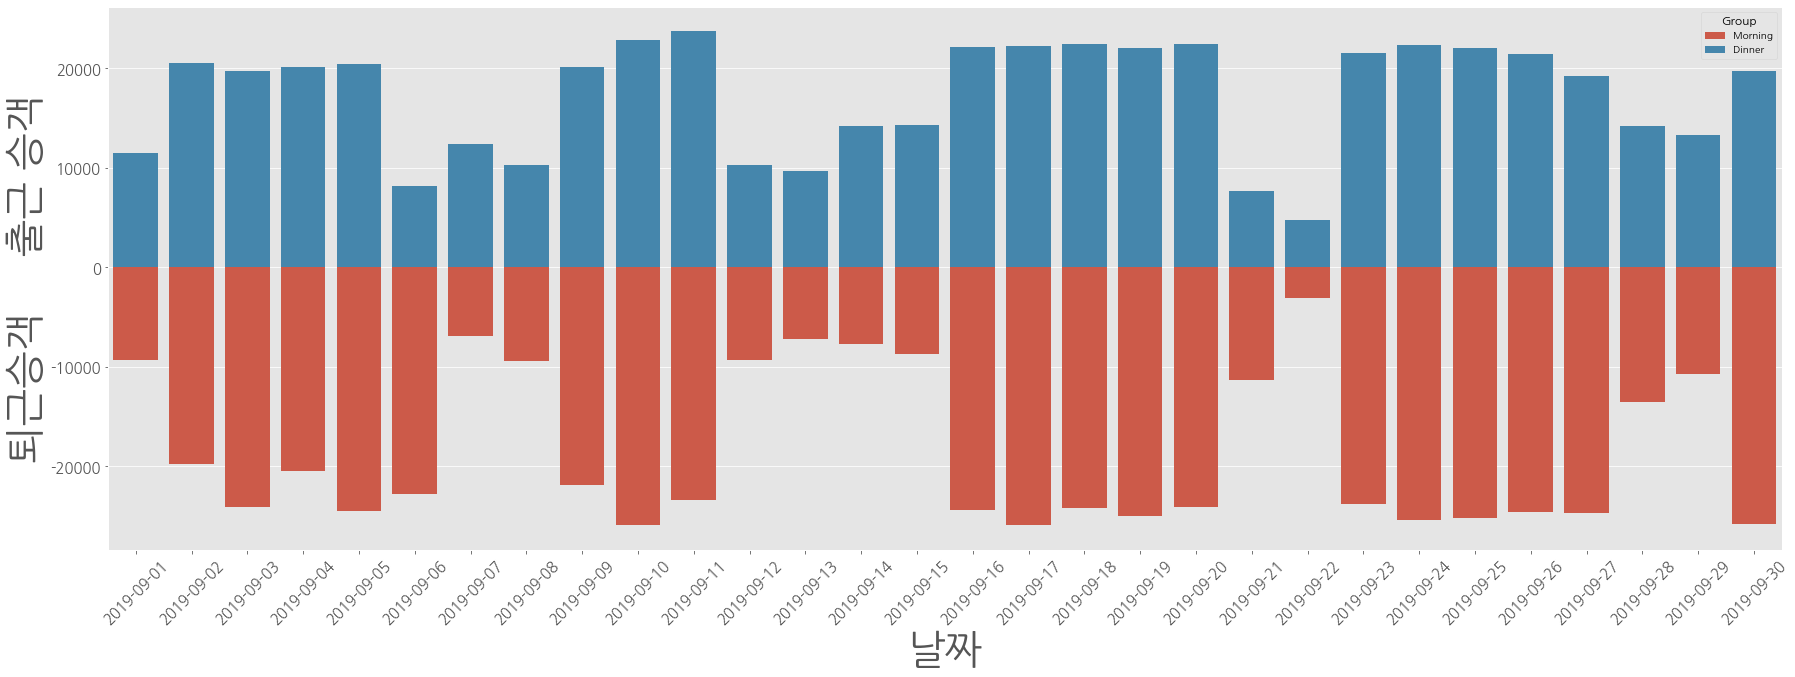

In [3]:
plt.rcParams["axes.unicode_minus"] = False

# 날짜별로 집계
data = train.groupby("date", as_index = False).sum()

# 출근 인원
data["Morning"] = data["8~9_ride"] + data["8~9_takeoff"]

# 퇴근 인원
data['Dinner'] = data['18~20_ride']

# 날짜, 출퇴근 이용량만 추출
data = data[["date", "Morning", "Dinner"]]

# 출근 승하차객
data_1 = data[["date", "Morning"]]
data_1["Group"] = "Morning"
data_1.columns = ["date", "Passanger", "Group"]
data_1["Passanger"] = -data_1["Passanger"]

# 퇴근 승하차객
data_2 = data[["date", "Dinner"]]
data_2["Group"] = "Dinner"
data_2.columns = ["date", "Passanger", "Group"]

# Merge
data_3 = pd.concat([data_1, data_2])

# Graph
fig = plt.figure(figsize=(30,10))
fig.patch.set_facecolor('xkcd:white')
ax = sns.barplot(x="date", y="Passanger", hue="Group",data=data_3, dodge=False)
plt.xlabel("날짜", fontsize=40)
plt.ylabel("퇴근승객     출근 승객", fontsize=40)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

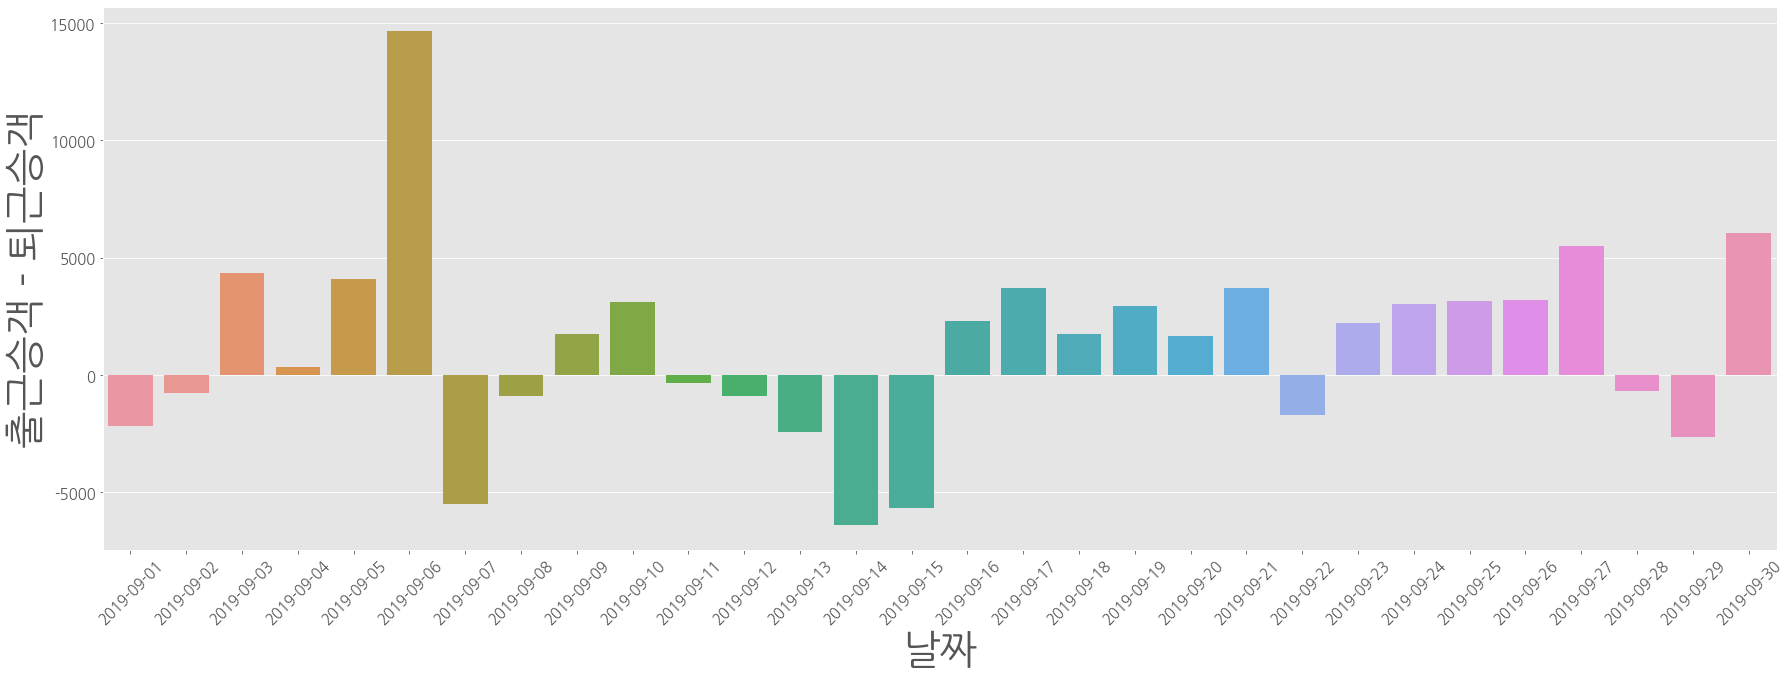

In [4]:
data["Morning-Dinner"] = data["Morning"] - data["Dinner"]
# Graph
fig = plt.figure(figsize=(30,10))
fig.patch.set_facecolor('xkcd:white')
ax = sns.barplot(x="date", y="Morning-Dinner",data=data, dodge=False)
plt.xticks(rotation=45, fontsize=15)
plt.xlabel("날짜", fontsize=40)
plt.ylabel("출근승객 - 퇴근승객", fontsize=40)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# **4. 정류장별 출퇴근 이용량의 차이**

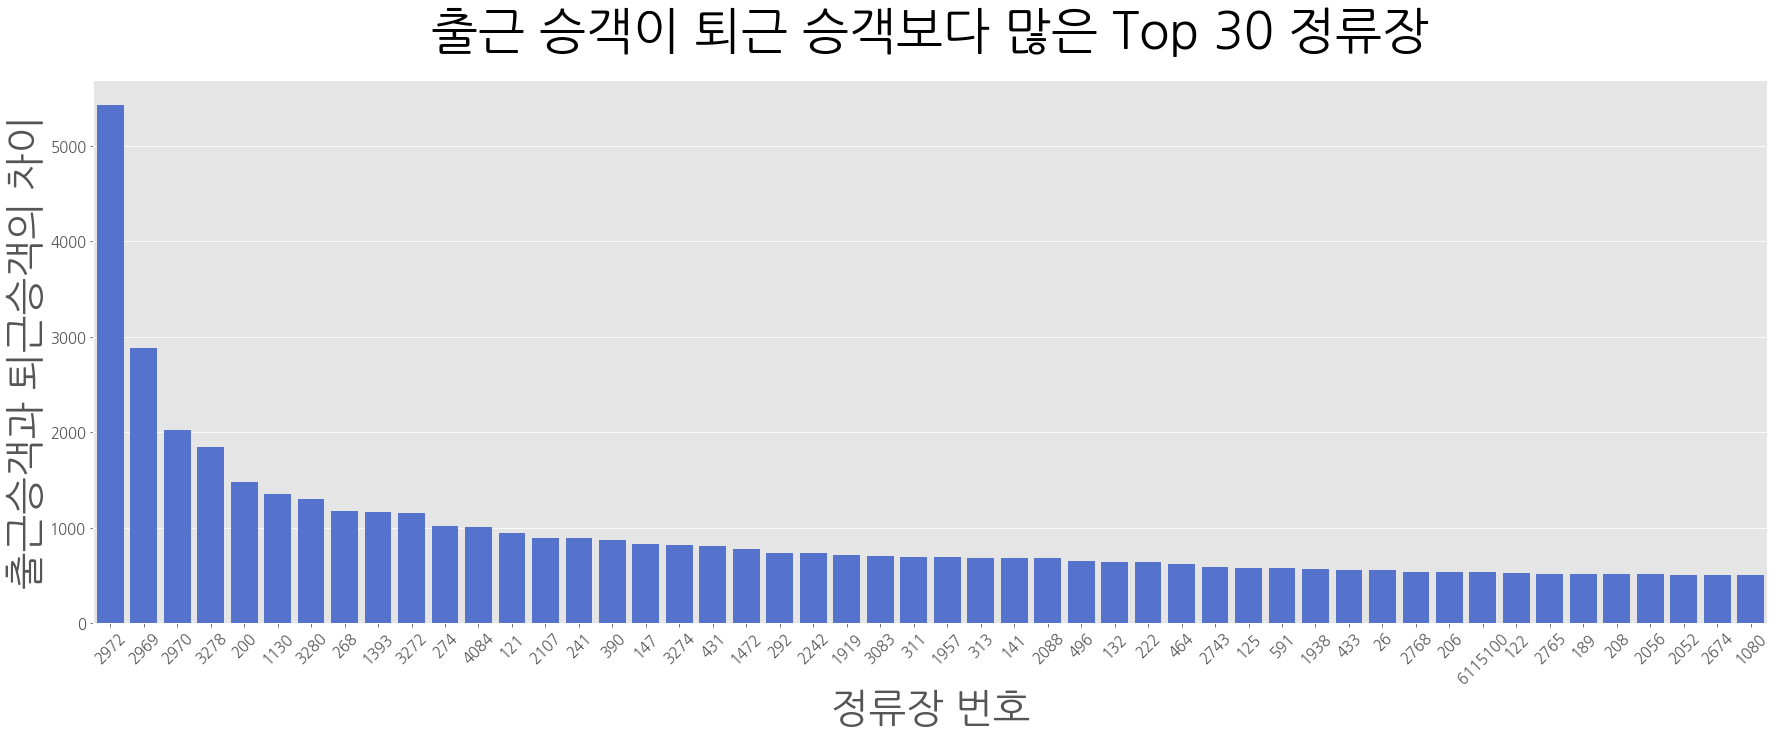

In [5]:
data = train.groupby("station_code", as_index = False). sum()

# 출근 인원
data["Morning"] = data["8~9_ride"] + data["8~9_takeoff"]

# 퇴근 인원
data['Dinner'] = data['18~20_ride']

# 필요한 피쳐만 추출
data = data[["station_code", "latitude", "longitude", "Morning", "Dinner"]]

# 출근양과 퇴근양의 차이
data["Morning-Dinner"] = data["Morning"] - data["Dinner"]

# 촐근 - 퇴근의 Top 30
data_top = data.sort_values(by="Morning-Dinner", ascending = False)
data_top = data_top[0:50]

# Graph
fig = plt.figure(figsize=(30,10))
fig.patch.set_facecolor('xkcd:white')
sns.barplot(x="station_code", y="Morning-Dinner", data=data_top, order=data_top["station_code"], color="royalblue")
plt.title("출근 승객이 퇴근 승객보다 많은 Top 30 정류장", fontsize=50, position=(0.5, 1.05))
plt.xlabel("정류장 번호", fontsize=40)
plt.ylabel("출근승객과 퇴근승객의 차이", fontsize=40)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

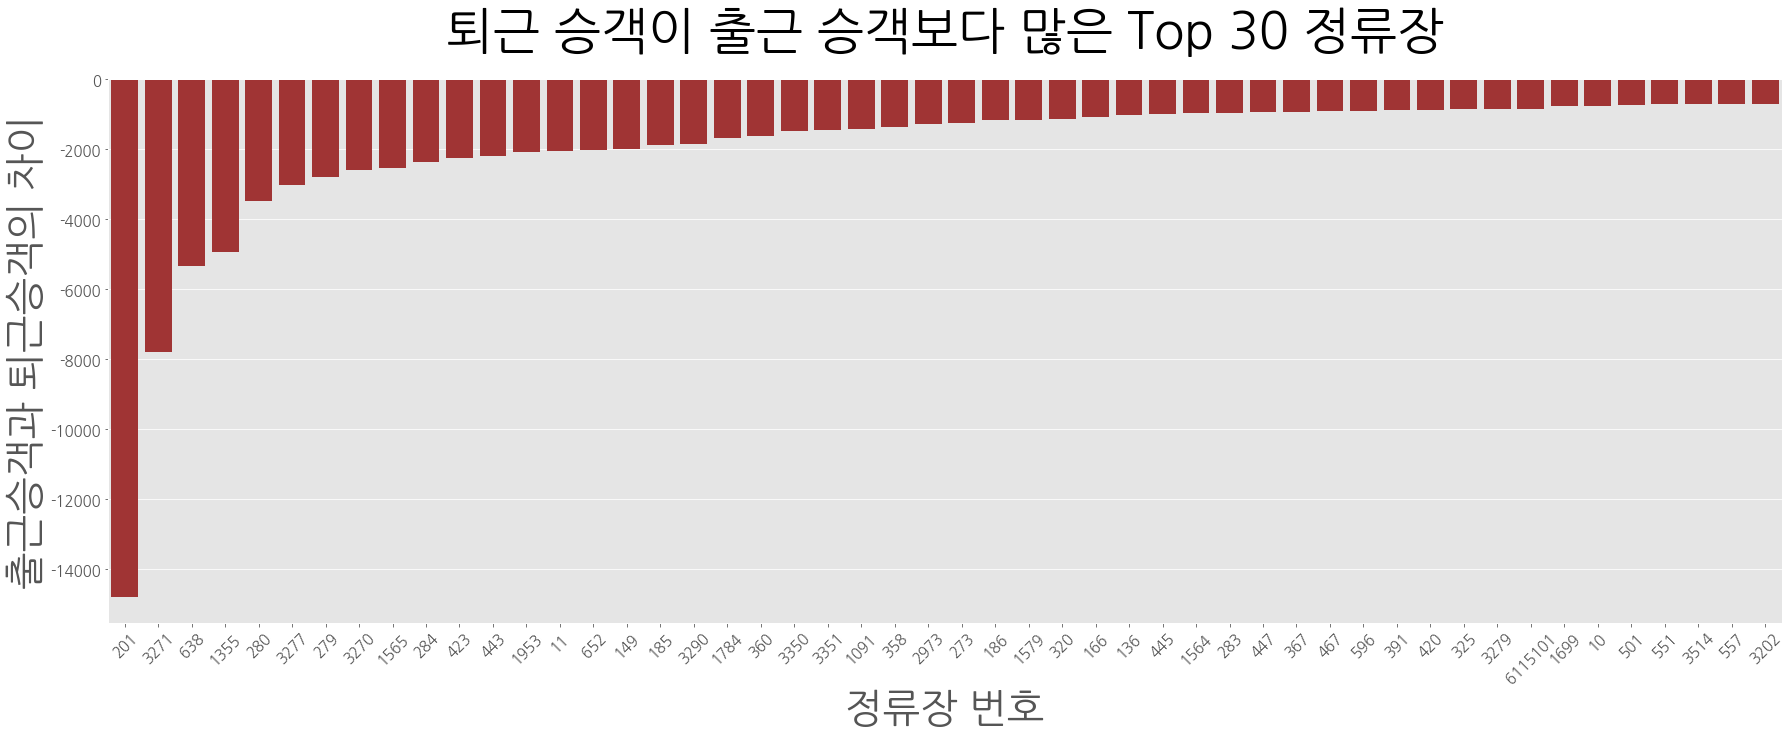

In [6]:
data = train.groupby("station_code", as_index = False). sum()

# 출근 인원
data["Morning"] = data["8~9_ride"] + data["8~9_takeoff"]

# 퇴근 인원
data['Dinner'] = data['18~20_ride']

# 필요한 피쳐만 추출
data = data[["station_code", "latitude", "longitude", "Morning", "Dinner"]]

# 출근양과 퇴근양의 차이
data["Morning-Dinner"] = data["Morning"] - data["Dinner"]

# 촐근 - 퇴근의 Bottom 30
data_bottom = data.sort_values(by="Morning-Dinner", ascending = True)
data_bottom = data_bottom[0:50]

# Graph
fig = plt.figure(figsize=(30,10))
fig.patch.set_facecolor('xkcd:white')
sns.barplot(x = "station_code", y = "Morning-Dinner", data = data_bottom, 
            order =data_bottom["station_code"], color="firebrick")
plt.title("퇴근 승객이 출근 승객보다 많은 Top 30 정류장", fontsize=50, position=(0.5, 1.05))
plt.xlabel("정류장 번호", fontsize=40)
plt.ylabel("출근승객과 퇴근승객의 차이", fontsize=40)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [7]:
data_top_30 = data[data['station_code'].isin(list(data_top.index))]

addr2 = train[['station_code','latitude','longitude']] # 정류장 이름, 위도, 경도 뽑아내기
addr2 = addr2.drop_duplicates() # 위치 정보가 중복될 수 있으므로 중복 행 제거
data_top_30 = addr2[addr2['station_code'].isin(list(data_top.index))]

# 초기 지도 객체 생성
map_osm = folium.Map(location=[33.3967, 126.5321], zoom_start = 10)

# Top 10 포인트
for item in data_top_30.index:
    lat = data_top_30.loc[item, 'latitude']
    long = data_top_30.loc[item, 'longitude']
    folium.Marker([lat, long], #위도 경도
        icon = folium.Icon(icon='cloud')
    ).add_to(map_osm)

data_bottom_30 = data[data['station_code'].isin(list(data_bottom.index))]

addr2 = train[['station_code','latitude','longitude']] # 정류장 이름, 위도, 경도 뽑아내기
addr2 = addr2.drop_duplicates() # 위치 정보가 중복될 수 있으므로 중복 행 제거
data_bottom_30 = addr2[addr2['station_code'].isin(list(data_bottom.index))]


# Bottom 10 포인트
for item in data_bottom_30.index:
    lat = data_bottom_30.loc[item, 'latitude']
    long = data_bottom_30.loc[item, 'longitude']
    folium.Marker([lat, long],
        icon = folium.Icon(color="red", icon='info-sign')
    ).add_to(map_osm)
map_osm

In [8]:
# Data Setting
data = train.groupby("station_code", as_index = False).sum()
data["Morning"] = data["8~9_ride"] + data["8~9_takeoff"]
data['Dinner'] = data['18~20_ride']
data["Morning-Dinner"] = data["Morning"] - data["Dinner"]
data["TOTAL"] = data["Morning"] + data["Dinner"]

# 촐근 - 퇴근의 Top 500
data_top = data.sort_values(by="Morning-Dinner", ascending = False)
data_top = data_top[0:50]

# 촐근 - 퇴근의 Bottom 500
data_bottom = data.sort_values(by="Morning-Dinner", ascending = True)
data_bottom = data_bottom[0:50]

data_top_50 = data[data['station_code'].isin(list(data_top.index))]
data_bottom_50 = data[data['station_code'].isin(list(data_bottom.index))]

TOTAL_PASSANGER = data["TOTAL"].sum()
TOP30_PASSANGER = data_top_50["TOTAL"].sum()
BOTTOM30_PASSANGER = data_bottom_50["TOTAL"].sum()

In [9]:
df = {'GROUP':  ["승차가 하차보다 많은 TOP 30", "하차가 승차보다 많은 TOP 30", "나머지"],
      'PASSANGER':  [TOP30_PASSANGER, BOTTOM30_PASSANGER, TOTAL_PASSANGER - TOP30_PASSANGER - BOTTOM30_PASSANGER],
      'PERCENT' :  [TOP30_PASSANGER/TOTAL_PASSANGER, BOTTOM30_PASSANGER/TOTAL_PASSANGER, 
                    (TOTAL_PASSANGER - TOP30_PASSANGER - BOTTOM30_PASSANGER)/TOTAL_PASSANGER],
       "OBS PER" : [30/len(data), 30/len(data), (len(data)-60)/len(data)]}

df = pd.DataFrame(df)
df

,GROUP,PASSANGER,PERCENT,OBS PER
0,승차가 하차보다 많은 TOP 30,47872.0,0.044771,0.00842
1,하차가 승차보다 많은 TOP 30,32552.0,0.030443,0.00842
2,나머지,988844.0,0.924786,0.98316


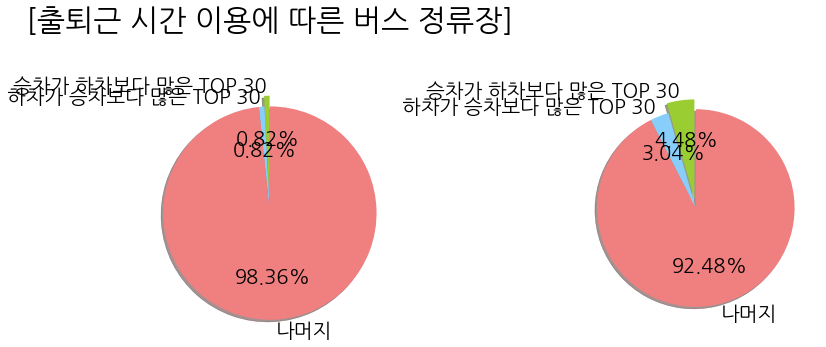

In [10]:
# importing library and set figure size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 10]

# information of groups
group_names = ["승차가 하차보다 많은 TOP 30", "하차가 승차보다 많은 TOP 30", "나머지"]
group_sizes = [47872, 32552, 988844]
group_colors = ['yellowgreen', 'lightskyblue', 'lightcoral']
group_explodes = (0.1, 0, 0) # explode 1st slice

# Pie chart
plt.subplot(222)
plot1 = plt.pie(group_sizes, 
        explode=group_explodes, 
        labels=group_names,
        colors=group_colors, 
        autopct='%1.2f%%', # second decimal place
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 20}) # text font size

# information of groups
group_names = ["승차가 하차보다 많은 TOP 30", "하차가 승차보다 많은 TOP 30", "나머지"]
group_sizes = [30,30,3600]
group_colors = ['yellowgreen', 'lightskyblue', 'lightcoral']
group_explodes = (0.1, 0, 0) # explode 1st slice

# Pie chart
plt.subplot(221)
plot2 = plt.pie(group_sizes, 
        explode=group_explodes, 
        labels=group_names,
        colors=group_colors, 
        autopct='%1.2f%%', # second decimal place
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 20}) # text font size

plt.axis('equal') #  equal length of X and Y axis
plt.title('[출퇴근 시간 이용에 따른 버스 정류장]', fontsize=30, position=(0.5, 1.0+0.2))
plt.show()